In [2]:
!pip install arff
import pandas as pd
import arff
data_freq = arff.load('C:/Users/Gina/Downloads/freMTPL2freq.arff')
df_freq = pd.DataFrame(data_freq, columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower",
"VehAge","DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"])
data_sev = arff.load('C:/Users/Gina/Downloads/freMTPL2sev.arff')
df_sev = pd.DataFrame(data_sev, columns=["IDpol", "ClaimAmount"])

  Using cached arff-0.9.tar.gz (4.7 kB)
  Created wheel for arff: filename=arff-0.9-py3-none-any.whl size=4971 sha256=886c05dba58dbe38cb03b325620398884a211e8c667c8276000d0f2127ad2609
  Stored in directory: c:\users\gina\appdata\local\pip\cache\wheels\fe\81\bd\4ae90e24ba860304e375da219f9205b2586dbee255f3ee70e2
Successfully built arff


In [3]:
print(df_freq.head())

   IDpol  ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  BonusMalus  \
0    1.0      1.0      0.10  'D'       5.0     0.0     55.0        50.0   
1    3.0      1.0      0.77  'D'       5.0     0.0     55.0        50.0   
2    5.0      1.0      0.75  'B'       6.0     2.0     52.0        50.0   
3   10.0      1.0      0.09  'B'       7.0     0.0     46.0        50.0   
4   11.0      1.0      0.84  'B'       7.0     0.0     46.0        50.0   

  VehBrand   VehGas  Density Region  
0    'B12'  Regular   1217.0  'R82'  
1    'B12'  Regular   1217.0  'R82'  
2    'B12'   Diesel     54.0  'R22'  
3    'B12'   Diesel     76.0  'R72'  
4    'B12'   Diesel     76.0  'R72'  


In [4]:
print(df_sev.head())

       IDpol  ClaimAmount
0     1552.0       995.20
1  1010996.0      1128.12
2  4024277.0      1851.11
3  4007252.0      1204.00
4  4046424.0      1204.00


Nach Einlesen der Daten mittels des zur Verfügung gestellten Codes wird im nächsten Schritt die explorative Datenanalyse vorgenommen. 

Da in den Download-Files bereits die Dimensionen der Datensätze als auch die Anzahl der Features gegeben ist, können diese Schritte übersprungen werden. Außerdem muss kein Algorithmus zum Handling von Missing Values implementiert werden, da diese ebenfalls nicht im Datensatz vorhanden sind. 

Zu beachten ist, dass Versicherungsnehmer selbstverständlich auch keine Schäden aufweisen können. Für diesen Fall kann die Zielvariable auf 0 gesetzt werden, da ohne Schäden auch keine Versicherungsleistung in Anspruch genommen werden muss. 
Die Features lassen sich in zwei Klassen unterteilen, kontinuierliche Features und kategorische Features. Die Art der Features ist bereits in der Beschreibung des Datensatzes angegeben. Es handelt sich um acht numerische Features. Eines davon wird verwendet, um die Zielvariable zu berechnen und wird deshalb nicht für das Berechnen der zu erwarteten Schadenssumme pro Jahr verwendet (starke Korrelation mit Zielvariable möglich). Die IDpol ist außerdem nur die Kennnummer des vertrages. Daher wird auch sie nicht zur Berechnung der Zielvariable benötigt, ist allerdings von entscheidender Bedeutung für das Zusammenführen der beiden Datensätze. 

Die Variablen "Claim", "VehPower", "VehAge", "DrivAge" und "Density" können als kontinuierliche Features interpretiert werden, auch wenn bei allen Features außer "Density" nur ganzzahlige Werte möglich sind. 

Auch bei "BonusMalus" sind nur ganzzahlige Werte möglich. Da dies mit den deutschen Schadensfreiheitsklassen vergleichbar ist, sollten hierbei also Werte zwischen 0 und 100 möglich sein, die einen Prozentsatz zur Reduktion der Versicherungssumme definieren. Aufgrund der fehlenden Kenntnisse zur Schrittweite im französischem Versicherungssystem werde ich für diese Variable zunächste einen Plot für die zugehörige Verteilung erstellen und im Anschluss festlegen, ob diese Variable als kontinuierliche oder kategorielle Variable zu betrachten ist. 

Die Variablen "Area", "VehBrand", "VehGas" und "Region" sind kategorische Variablen. Hier ist zu beachten, dass sowohl die Variable "Region" als auch die Variable "Area" durch den Wohnort des Versicherungsnehmers definiert sind. Da es im Datensatz 22 verschiedene Werte für die "Region", aber nur 6 verschiedene Einträge für "Area" gibt, ist davon auzugehen, dass "Area" eine Übergruppe für die "Region" ist. Hier ist durch Korrelationsanalysen festzustellen, ob dies auch tatsächlich zutreffend ist. 

Für die explorative Datenanalyse werde ich in foglenden Schritten vorgehen: 
1) Berechnung der Zielvariable und Zusammenführung der Datensätze 

2) Plotten der Verteilungen der verschiedenen Features 

3) Bestimmung von Korrelationen zwischen den Features und der Zielvariable 


In [5]:
# Berechnung der Zielvariable

# Vorbereitung des df_sev-Dataframes
df_sev_aggregated = df_sev.groupby('IDpol', as_index=False).agg({'ClaimAmount': 'sum'})
print("Aggregated dimension: ", df_sev_aggregated.shape, ", Original dimension: ", df_sev.shape) 

# Erkenne: nun weniger Einträge als vorher, Berechnung daher erfolgreich

# Merge Dataframes, setze ClaimAmount = 0, falls er nicht in df_freq verfügbar ist 
df_merged = pd.merge(df_freq, df_sev_aggregated, on='IDpol', how='left')
df_merged['ClaimAmount'].fillna(0, inplace=True)

print(df_merged.head()) # Kontrolle zeigt: Erfolgreich 

# Berechnung der Zielvariable,stelle sicher, dass diese auch funktioniert, falls Exposure = 0
df_merged['AnnualClaimAmount'] = df_merged.apply(
    lambda row: row['ClaimAmount'] / row['Exposure'] if row['Exposure'] > 0 else 0, axis=1)

# Setze 'IDpol' als RowID
df_merged.set_index('IDpol', inplace=True)

# Entferne die Spalten 'Exposure' und 'ClaimAmount'
df_merged.drop(columns=['Exposure', 'ClaimAmount'], inplace=True)

# Verschiebe 'AnnualClaimAmount' an die erste Stelle
cols = ['AnnualClaimAmount'] + [col for col in df_merged.columns if col != 'AnnualClaimAmount']
df_merged = df_merged[cols]

# Kontrolle
print(df_merged.head())

Aggregated dimension:  (24950, 2) , Original dimension:  (26639, 2)
   IDpol  ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  BonusMalus  \
0    1.0      1.0      0.10  'D'       5.0     0.0     55.0        50.0   
1    3.0      1.0      0.77  'D'       5.0     0.0     55.0        50.0   
2    5.0      1.0      0.75  'B'       6.0     2.0     52.0        50.0   
3   10.0      1.0      0.09  'B'       7.0     0.0     46.0        50.0   
4   11.0      1.0      0.84  'B'       7.0     0.0     46.0        50.0   

  VehBrand   VehGas  Density Region  ClaimAmount  
0    'B12'  Regular   1217.0  'R82'          0.0  
1    'B12'  Regular   1217.0  'R82'          0.0  
2    'B12'   Diesel     54.0  'R22'          0.0  
3    'B12'   Diesel     76.0  'R72'          0.0  
4    'B12'   Diesel     76.0  'R72'          0.0  
       AnnualClaimAmount  ClaimNb Area  VehPower  VehAge  DrivAge  BonusMalus  \
IDpol                                                                           
1.0          

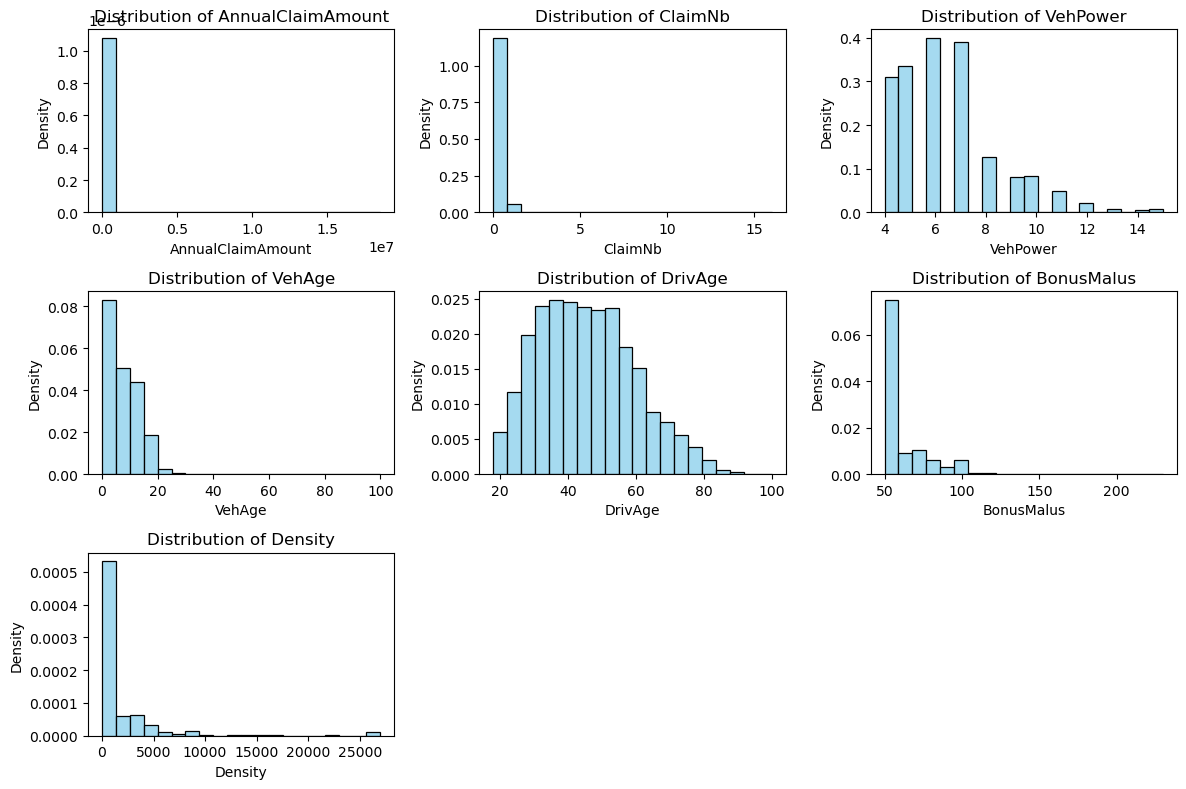

In [7]:
# Plotten der Verteilung der verschiedenen Features
import matplotlib.pyplot as plt
import seaborn as sns

# Zunächst: Kontinuierliche Features
# Liste der kontinuierlichen Features
features = ["AnnualClaimAmount", "ClaimNb", "VehPower", "VehAge", "DrivAge", "BonusMalus", "Density"]

# Sicherstellen, dass die Spalten numerisch sind und fehlende Werte behandelt werden
df_merged[features] = df_merged[features].apply(pd.to_numeric, errors='coerce')  # Wandle in numerische Werte um
df_merged.dropna(subset=features, inplace=True)  # Entferne Zeilen mit fehlenden Werten

# Erstelle die Barplots mit Dichteverteilung
plt.figure(figsize=(12, 8))  # Setze eine passende Figurengröße

for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)  # Ordne die Plots in einem 2x3 Raster an
    
    # Erstelle den Barplot (Histogramm)
    sns.histplot(df_merged[feature], bins=20, color="skyblue", edgecolor="black", stat="density")

    # Setze den Titel und Achsenbeschriftungen
    plt.title(f'Distribution of {feature}', fontsize=12)
    plt.xlabel(feature)
    plt.ylabel('Density')

plt.tight_layout()  # Verhindert das Überlappen der Plots
plt.show()

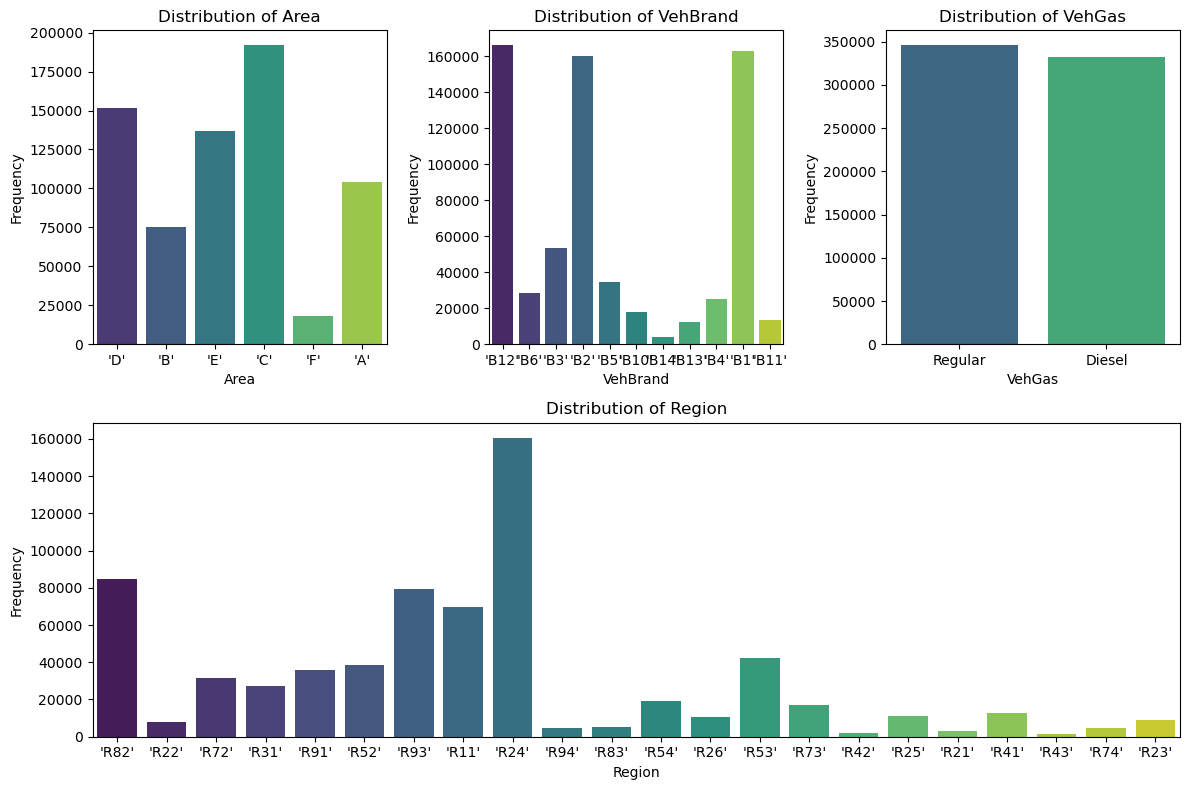

In [8]:
# Plot der kategorischen Features

# Liste der kategorischen Features
categorical_features = ["Area", "VehBrand", "VehGas", "Region"]

# Erstelle die Barplots für die kategorischen Features
plt.figure(figsize=(12, 8))  # Setze eine passende Figurengröße

# Erstelle die ersten drei Plots (Area, VehBrand, VehGas)
for i, feature in enumerate(categorical_features[:-1], 1):
    plt.subplot(2, 3, i)  # Ordne die Plots in einem 2x2 Raster an
    sns.countplot(data=df_merged, x=feature, palette="viridis")
    plt.title(f'Distribution of {feature}', fontsize=12)
    plt.xlabel(feature)
    plt.ylabel('Frequency')

# Erstelle den letzten Plot für 'Region' und vergrößere ihn
plt.subplot(2, 1, 2)  # Belege die untere Zeile mit doppelter Größe
sns.countplot(data=df_merged, x='Region', palette="viridis")
plt.title('Distribution of Region', fontsize=12)
plt.xlabel('Region')
plt.ylabel('Frequency')


plt.tight_layout()  # Verhindert das Überlappen der Plots
plt.show()

Die Plots der Korrelationen zeigen bereits folgende Erkenntnisse: 

- Die unabhängigen Variablen sind (mit Ausnahme von DrivAge) nicht normalverteilt und auch nicht annähernd normalverteilt. Da die meisten ML-Modelle und auch DeepLearning-Modelle von einer Normalverteilung der Features ausgehen, kann dies die Qualität des Lernens verschlechtern. 
- Die meisten Versicherungsnehmer haben in dem Zeitraum keine Schäden, wodurch sich der Barplot für die Zielvariable um 0 zentriert. Dies kann ebenso die Qualität der Vorhersage mindern. 
- Die meisten Variablen scheinen annähernd einer exponentiellen Verteilung zu folgen. Ebenso könnte man sie mittels einer Gamma-Distribution (k kleiner 1) modellieren. 

Für die folgende Korrelationsanalyse werden die kategorischen Variablen encoded. Dafür wird jeder Eintrag eine eigene Spalte, diese Spalte kann die Werte 0 (Eintrag entspricht nicht Eintrag) oder 1 (Eintrag stimmt überein) annehmen. Dieses Encoding ist bereits eine Vorbereitung für das folgende ML/Deep Learning. 
Der Korrelationskoeffizient wurde mittels der Pearson-Korrelation berechnet. 

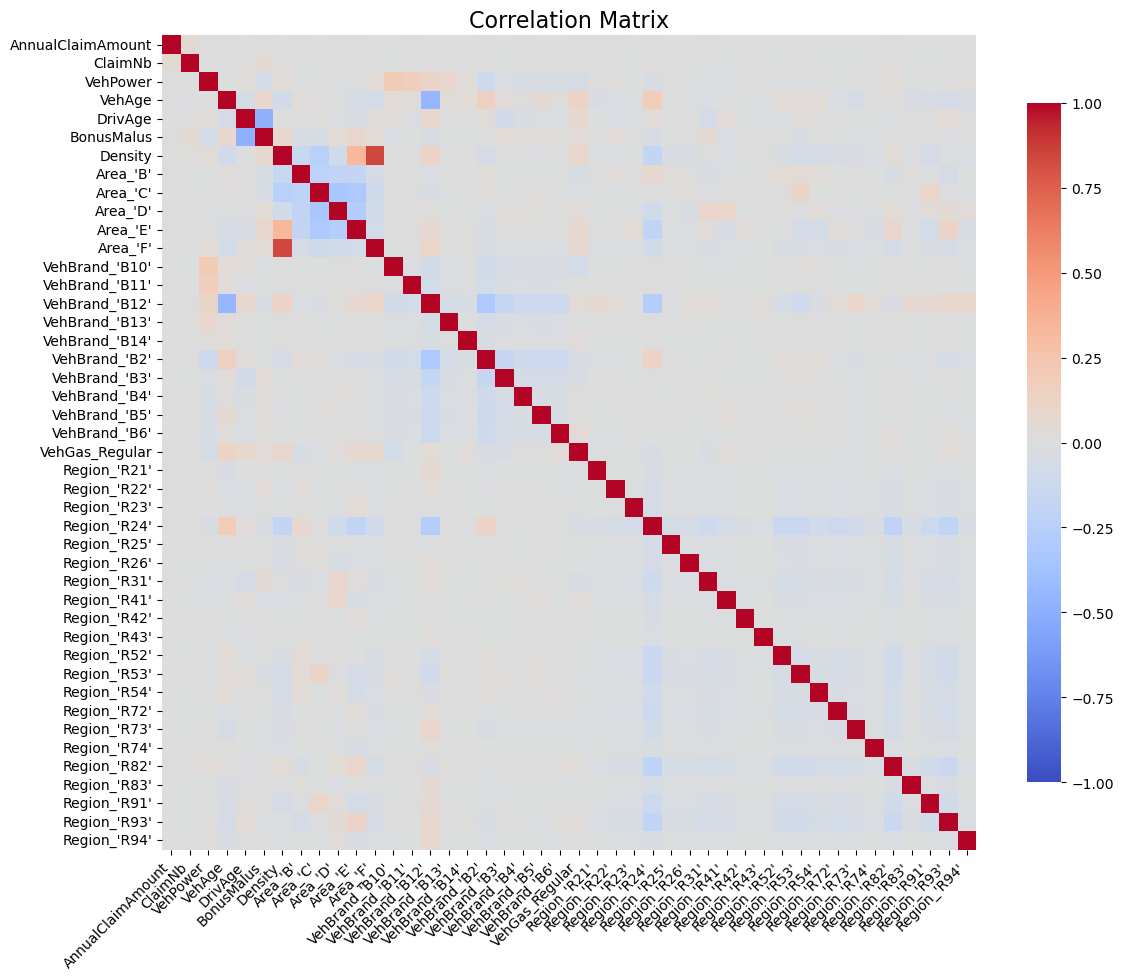

In [9]:
# Korrelationsanalyse

# Kategorische Variablen in numerische umwandeln
df_encoded = pd.get_dummies(df_merged, columns=["Area", "VehBrand", "VehGas", "Region"], drop_first=True)

# Berechne die Korrelationsmatrix für alle Variablen
correlation_matrix = df_encoded.corr()

# Setze die Figurgröße für die Heatmap
plt.figure(figsize=(12, 10))

# Erstelle die Heatmap ohne Einträge und mit der Skala von -1 bis 1
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", 
            square=True, cbar_kws={"shrink": .8}, vmin=-1, vmax=1)

# Setze den Titel und die Achsenbeschriftungen
plt.title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()  # Verhindert das Überlappen der Plots
plt.show()

Die Korrelationsanalyse zeigt eine Korrelaition zwiwschen der Bevölkerungsdichte und der Region. Die Zielvariable zeigt mit keiner der Variablen eine besonders starke oder schwache Korrelation. Eine weitere hohe Korrelation lässt sich zwischen dem Alter des Fahrers (DrivAge) und der franz. Schadensfreiheitsklasse (BonusMalus) feststellen. Insgesamt lassen sich keine besonders hohen Korrelationen zwischen einzelnen Variablen feststellen. Daher erscheint es nicht sinnvoll, für das folgenden maschinelle Lernen nur einen reduzierten Variablensatz zu verwenden. 

Insbesondere Korrelieren auch die Variablen Region und Area nicht stark miteinander. Daher kann die Vermutung, dass die Region eine weitere Verfeinerung der Area ist, auf dem ersten Blick verworfen werden. Eine tiefere Analyse könnte allerdings zeigen, ob diese zutreffend ist und in diesem Fall kann es sinnvoll sein, nur eine der beiden Kategorieren zu verwenden. 

Im nächsten Schritt wird das Feature Engineering durchgeführt. Alle anderen Variablen (außer Zielvariable) werden mittels Min-Max-Normalisierung auf Werte zwischen 1 und -1 skaliert. Dies wird vorgenommen, damit alle Variablen in der gleichen Größenordnung vorliegen. Für die kontinuierlichen Werte ist theoretisch auch eine Z-Score Normalisierung möglich. Hier habe ich mich allerdings dagegen entschieden, da bei den meisten keine (näherungsweise) Normalverteilung vorliegt. 

In [10]:
# Min-Max normalization

# Min-Max-Normalisierung auf den Bereich [-1, 1]
def min_max_normalize(df):
    # Spalten, die nicht skaliert werden sollen
    columns_to_scale = df.columns[df.columns != 'AnnualClaimAmount']
    
    # Werte für die Skalierung anpassen
    for column in columns_to_scale:
        min_value = df[column].min()
        max_value = df[column].max()
        
        # Skaliere die Werte auf den Bereich von -1 bis 1
        df[column] = 2 * (df[column] - min_value) / (max_value - min_value) - 1
    
    return df

# Wende die Normalisierung auf den DataFrame an
normalized_df = pd.DataFrame(min_max_normalize(df_encoded))

# Kontrolle
print(normalized_df.head())
print(normalized_df.shape)

       AnnualClaimAmount  ClaimNb  VehPower  VehAge   DrivAge  BonusMalus  \
IDpol                                                                       
1.0                  0.0   -0.875 -0.818182   -1.00 -0.097561        -1.0   
3.0                  0.0   -0.875 -0.818182   -1.00 -0.097561        -1.0   
5.0                  0.0   -0.875 -0.636364   -0.96 -0.170732        -1.0   
10.0                 0.0   -0.875 -0.454545   -1.00 -0.317073        -1.0   
11.0                 0.0   -0.875 -0.454545   -1.00 -0.317073        -1.0   

        Density  Area_'B'  Area_'C'  Area_'D'  ...  Region_'R53'  \
IDpol                                          ...                 
1.0   -0.909923      -1.0      -1.0       1.0  ...          -1.0   
3.0   -0.909923      -1.0      -1.0       1.0  ...          -1.0   
5.0   -0.996074       1.0      -1.0      -1.0  ...          -1.0   
10.0  -0.994444       1.0      -1.0      -1.0  ...          -1.0   
11.0  -0.994444       1.0      -1.0      -1.0  ...  

Beim vorliegenden Problem handelt es sich um eine Regression (kontinuierliche Zielvariable). Dafür kommen verschiedene Modelle infrage (kleine Auswahl hier): 
- Lineare Regression: Einfaches, weit verbreitetes Modell, dass häufig vor allem lineare Zusammenhänge gut beschreiben kann. Könnte durch unsere Encoding eine reduzierte Vorhersagekraft aufweisen. 
- Random Forest: Ensemble-Methode, dass durch die Kombination von mehreren Entscheidungsbäumen die Vorhersagegenauigkeit erhöht. Meist sehr robust und mit geringem Overfitting, gute Interpretierbarkeit. 
- Support Vector Regression: Methode der SVM, häufig für Regressionsaufgaben, gut für hochdimensionale Daten, kann auch nichtlineare Beziehungen betrachten, allerdings häufig geringe Stabilität
- Bayesian Regression: Anwendung des Naive-Bayes-Algorithmus auf Regression, die Unsicherheiten in den Messwerten berücksichtigt. Hier kann gut die Unsicherheit der Vorhersage quantifiziert werden. Da in unserem Fall die Messwerte allerdings nicht von Unsicherheiten belastet sind, wahrscheinlich ohne Vorteil. 
- Neuronale Netzwerke: Gut geeignet für komplexe Probleme, Größe des Datensatzes lässt in unserem Fall auch eine Verwendung zu. Gut geeignet auch für nichtlineare Probleme. Benötigt allerdings gute Optimierung, da ansonsten die Vorhersagekraft reduziert sein kann. 

Von diesen fünf Modellen scheinen Random Forest und Neuronale Netzwerke die höchsten Erfolgsaussichten zu besitzen. Daher wird einmal ein Random Forest in seiner Standardkonfiguration trainiert und im Anschluss ResNet (https://arxiv.org/abs/1512.03385) trainiert. Aufgrund der fehlenden Optimierung sind vom Random Forest bessere Ergebnisse zu erwarten. 

In [11]:
# Random Forest
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Merkmale und Zielvariable definieren
X = normalized_df.drop('AnnualClaimAmount', axis=1)  # Merkmale
y = normalized_df['AnnualClaimAmount']  # Zielvariable

# 80:20 Training/Test-Split erstellen, random_state = 42 für Vergleichbarkeit mit NN
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Regressor initialisieren
model = RandomForestRegressor(random_state=42)

# Modell trainieren
model.fit(X_train, y_train)

# Vorhersagen auf den Testdaten durchführen
y_pred = model.predict(X_test)

# Modell bewerten
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 1493506149.0931816
Mean Absolute Error: 807.3194867296095


In [14]:
# ResNet als Neural Network
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Add, Activation, BatchNormalization, Flatten
from tensorflow.keras.models import Model

# Merkmale und Zielvariable definieren
X = normalized_df.drop('AnnualClaimAmount', axis=1)  # Merkmale
y = normalized_df['AnnualClaimAmount']  # Zielvariable

# 80:20 Training/Test-Split erstellen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def resnet_block(x, units):
    shortcut = x
    
    # Erster Block
    x = Dense(units)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Zweiter Block
    x = Dense(units)(x)
    x = BatchNormalization()(x)

    # Die Dimensionen anpassen, falls nötig
    if shortcut.shape[-1] != x.shape[-1]:
        shortcut = Dense(x.shape[-1])(shortcut)  # Shortcut anpassen
    
    # Shortcut hinzufügen
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    return x

def create_resnet_model(input_shape):
    inputs = Input(shape=input_shape)
    
    x = Flatten()(inputs)
    
    # Mehrere ResNet-Blöcke hinzufügen
    for _ in range(3):  # Anzahl der Blöcke kann angepasst werden
        x = resnet_block(x, units=64)  # Anzahl der Einheiten kann angepasst werden
    
    outputs = Dense(1)(x)  # Ausgangsschicht für Regression
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

# Modell erstellen
input_shape = (X_train.shape[1],)  # Anzahl der Features
model = create_resnet_model(input_shape)

# Modell kompilieren mit MSE und MAE
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

# Modellübersicht anzeigen
model.summary()

# Modell trainieren
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# Modellbewertung
loss, mae, mse = model.evaluate(X_test, y_test)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 43)]         0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 43)           0           input_3[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 64)           2816        flatten_2[0][0]                  
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 64)           256         dense_10[0][0]                   
_______________________________________________________________________________________

Aufgrund der weiten Verbreitung, der bereits vorimplementierten Struktur in Keras sowie der guten Performance in der Bildverarbeitung (eigentliche Entwicklung von ResNet) wurde dieses Modell für die Verwendung als Vergleichsmodell als Deep Structure gewählt. 

Der Vergleich der Metrikn Mean Absolute Error und Mean Squared Error zeigen, dass ResNet im Vergleich zu Random Forest besser performt. Daher wird dieses Modell auch für die weiteren Schritte gewählt. In den weiteren Schritten wird nun die Robustheit anhand von 10 Random Train-Test-Splits evaluiert und außerdem wird der prozentuale Fehler berechnet und geplottet. Anschließend werden die wichtigsten Features mittels "permutation_importance" von sklearn berechnet. 

In [16]:
# Save first model for feature importance evaluation
mymodel = model 

# Robustness estimates
# Parameter für die Evaluierung
n_splits = 5
mae_scores = []
mse_scores = []

for i in range(n_splits):
    print(i)
    # 80:20 Training/Test-Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    
    def resnet_block(x, units):
        shortcut = x
        
        # Erster Block
        x = Dense(units)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        # Zweiter Block
        x = Dense(units)(x)
        x = BatchNormalization()(x)

        # Die Dimensionen anpassen, falls nötig
        if shortcut.shape[-1] != x.shape[-1]:
            shortcut = Dense(x.shape[-1])(shortcut)  # Shortcut anpassen
        
        # Shortcut hinzufügen
        x = Add()([x, shortcut])
        x = Activation('relu')(x)
        
        return x

    def create_resnet_model(input_shape):
        inputs = Input(shape=input_shape)
        
        x = Flatten()(inputs)
        
        # Mehrere ResNet-Blöcke hinzufügen
        for _ in range(3):  # Anzahl der Blöcke kann angepasst werden
            x = resnet_block(x, units=64)  # Anzahl der Einheiten kann angepasst werden
        
        outputs = Dense(1)(x)  # Ausgangsschicht für Regression
        model = Model(inputs=inputs, outputs=outputs)
        
        return model

    # Modell erstellen
    input_shape = (X_train.shape[1],)  # Anzahl der Features
    model = create_resnet_model(input_shape)

    # Modell kompilieren mit MSE und MAE
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    # Modell trainieren Runtime Estimate: only 3 epochs
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=32, verbose=1)

    # Modellbewertung
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    mae_scores.append(mae)
    mse_scores.append(mse)

# Mittelwerte und Standardabweichungen berechnen
mean_mae = np.mean(mae_scores)
std_mae = np.std(mae_scores)
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

# Ergebnisse ausgeben
print(f'Mean MAE over {n_splits} splits: {mean_mae:.4f} ± {std_mae:.4f}')
print(f'Mean MSE over {n_splits} splits: {mean_mse:.4f} ± {std_mse:.4f}')


0
Epoch 1/3
16951/16951 [==============================] - 36s 2ms/step - loss: 1520109056.0000 - mae: 573.2544 - val_loss: 694398080.0000 - val_mae: 431.7933
Epoch 2/3
16951/16951 [==============================] - 36s 2ms/step - loss: 1518879360.0000 - mae: 556.4163 - val_loss: 693262912.0000 - val_mae: 444.8587
Epoch 3/3
16951/16951 [==============================] - 37s 2ms/step - loss: 1518466304.0000 - mae: 609.3163 - val_loss: 693348608.0000 - val_mae: 712.9196
1
Epoch 1/3
16951/16951 [==============================] - 36s 2ms/step - loss: 1491967744.0000 - mae: 560.7175 - val_loss: 807873152.0000 - val_mae: 376.9860
Epoch 2/3
16951/16951 [==============================] - 36s 2ms/step - loss: 1490627200.0000 - mae: 553.8556 - val_loss: 806895680.0000 - val_mae: 875.0103
Epoch 3/3
16951/16951 [==============================] - 36s 2ms/step - loss: 1490183168.0000 - mae: 604.8524 - val_loss: 806871488.0000 - val_mae: 1033.0306
2
Epoch 1/3
16951/16951 [============================

Die vorliegenden Berechnungen zeigen, dass das gewählte Modell mit einer Standardabweichung von rund einem Drittel des MAE nicht stabil ist und weitere Optimierungsschritte nötig wären, um die Robustheit zu erhöhen. Dies kann z.B. über eine größere Anzahl an Epochs sichergestellt werden oder durch einen Split in Train-Test-Validation Set. Dadurch kann man im Training ein overfitting besser verhindern und somit auch die Robustheit erhöhen. 

            0
0  193.498306
1  323.959045
2  154.659790
3  241.336990
4  123.315292 IDpol
2122523.0    0.0
3173420.0    0.0
1188619.0    0.0
31400.0      0.0
3138755.0    0.0
Name: AnnualClaimAmount, dtype: float64


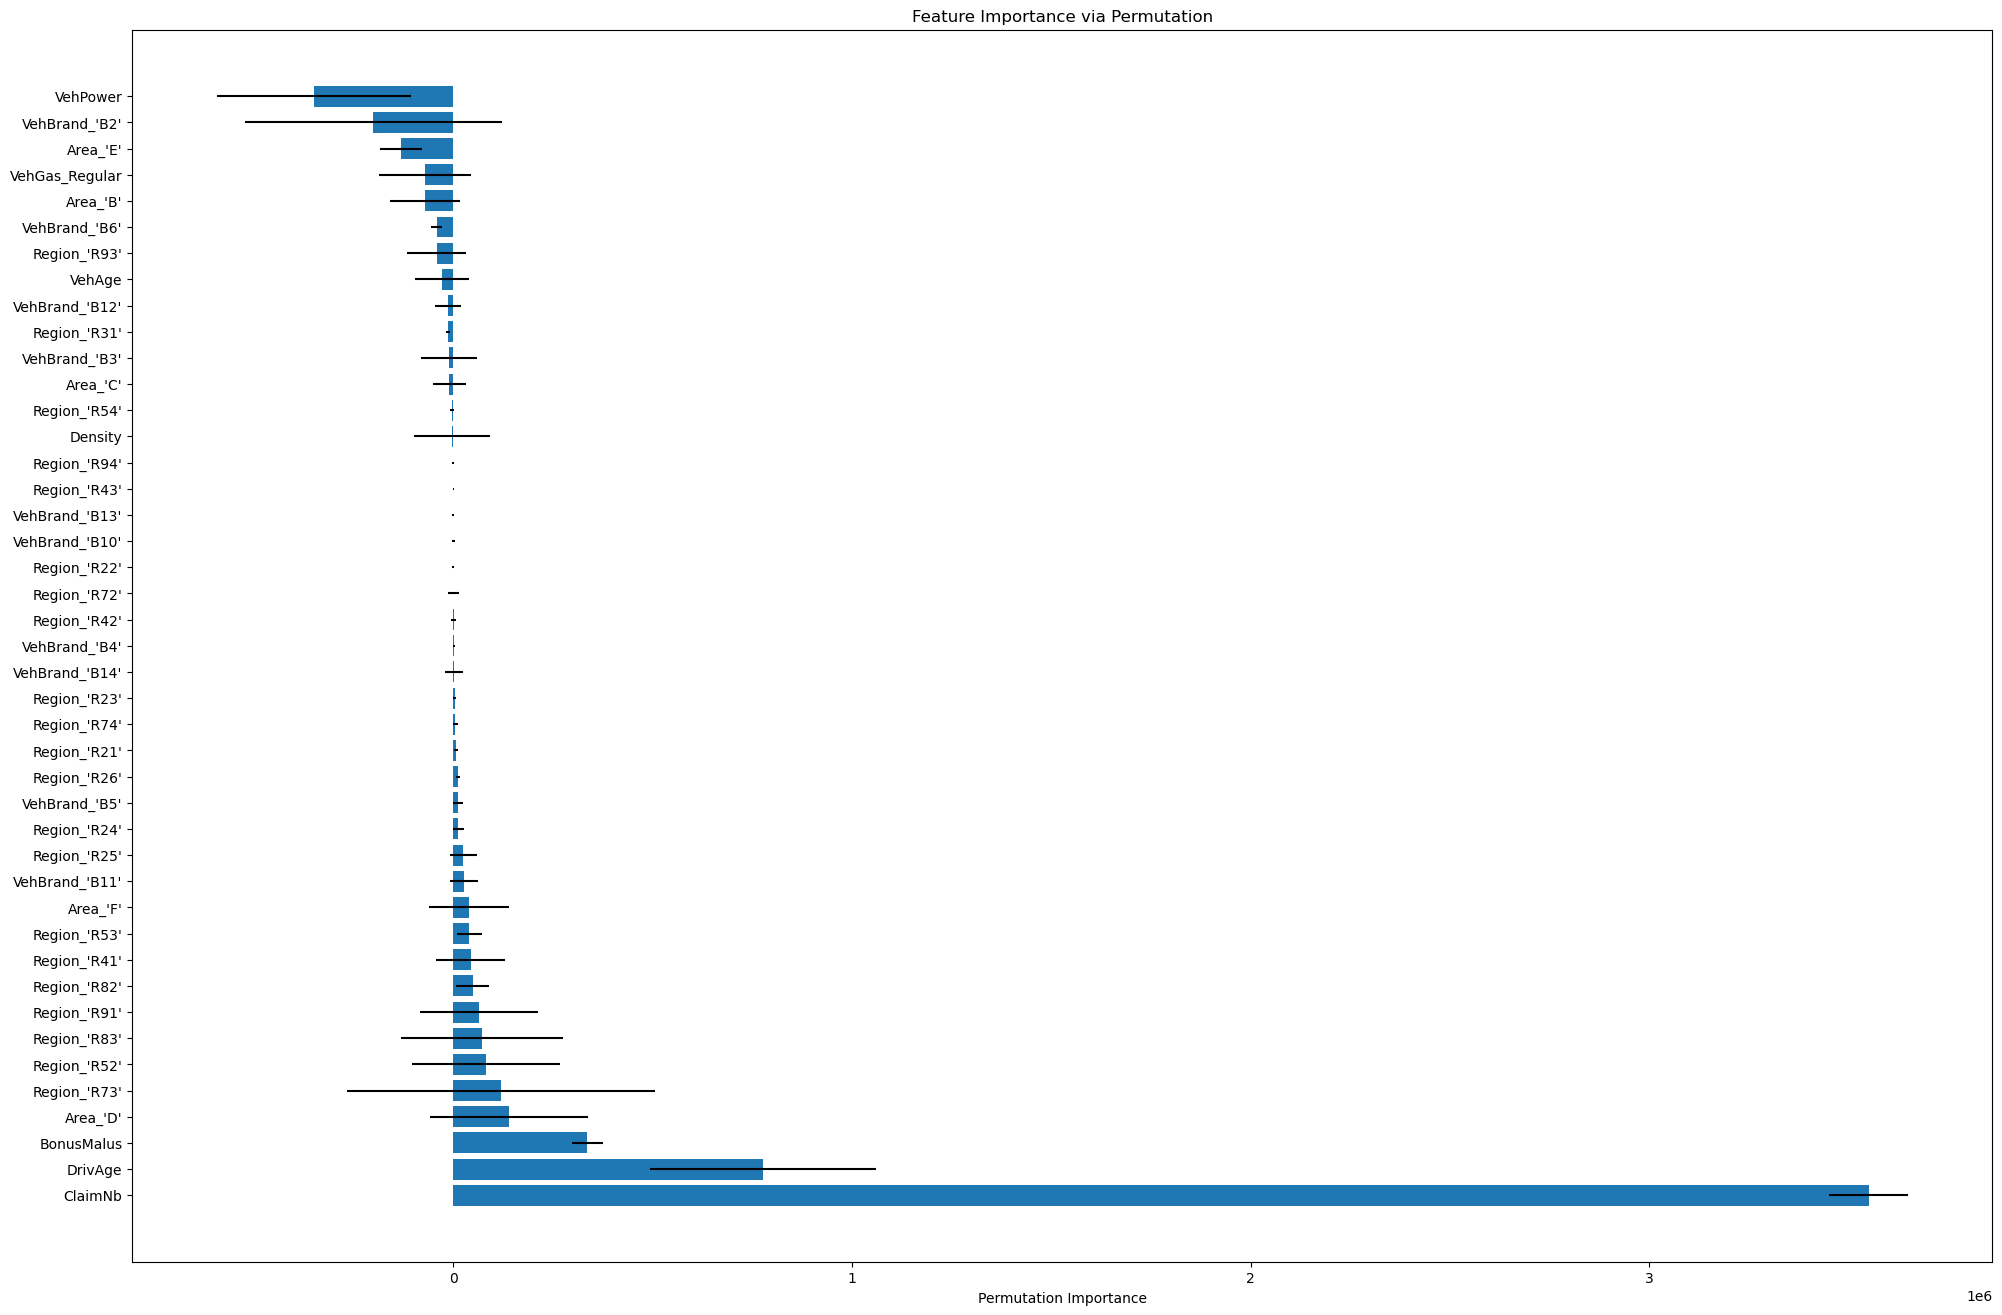

In [25]:
# Abschätzung der Feature Importance
from sklearn.inspection import permutation_importance

# 80:20 Training/Test-Split erstellen, random_state = 42, damit ursprüngliche Sets genutzt werden
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vorhersagen generieren
predictions = pd.DataFrame(mymodel.predict(X_test))

print(predictions.head(), y_test.head())

# Reduktion des Training/Test-Split auf 10 % des ursprünglichen Splits: 
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.01, random_state=42)

# Vorhersagen mit dem ursprünglichen Modell
original_score = mymodel.evaluate(X_test, y_test, verbose=0)

# Wrapper-Klasse für Keras-Modell
class KerasRegressorWrapper:
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, y):
        self.model.fit(X, y, epochs=3, batch_size=32, verbose=1)

    def predict(self, X):
        return self.model.predict(X).flatten()  # Flach machen für Regression
    
    def score(self, X, y):
        # Berechne den Mean Squared Error für den Score
        return -np.mean((self.predict(X) - y) ** 2)

# KerasRegressorWrapper-Instanz erstellen
keras_model = KerasRegressorWrapper(model)

# Permutation Feature Importance berechnen
result = permutation_importance(keras_model, X_test, y_test, n_repeats=10, random_state=42)

# Wichtigkeit der Features sortieren
sorted_idx = result.importances_mean.argsort()[::-1]

# Plotten der wichtigsten Features
plt.rcParams['figure.figsize'] = [24, 16]
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], xerr=result.importances_std[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), X.columns[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance via Permutation")  
plt.show()



Die Grundidee der permutation importance besteht darin, dass die Werte des Features zufällig neu zugeordnet werden und im Anschluss wird untersucht, wie dies die Modellgenauigkeit beeinflusst. Je höher der Einfluss auf die Genauigkeit ist, desto größer ist die Importance des Features. Damit die Berechnung schneller abgeschlossen werden kann, werden außerdem nur 1 % des ursprünglichen Testsatzes zur Beurteilung der Importance verwendet. Die Verwendung des gesamten Trainingsatzes kann zu veränderten Importance-Parametern und damit auch einer veränderten Beurtilung vühren. 

Unsere Berechnung zeigt, dass die größten Einflussfaktoren, die die Versicherungssumme erhöhen das Alter des Fahrers und die Anzahl der Schäden ist. Da beides mit dem Bonus/Malus korreliert, ist auch dieser ein guter Vorhersageindikator. Die meisten Regionen und Automarken haben auf die Vorhersage keinen bis einen geringen Einfluss. Ausnahmen hierbei sind insbesondere die Regionen D und E. Die Density weißt eine hohe Schwankung auf, hat aber im Allgemeinen weder einen positiven noch einen negativen Einfluss. Für eine tiefere Analyse wäre es sinnvoll, die verschiedenen Regionen näher zu betrachten, die einen (positiven oder negativen) Einfluss auf die Vorhersage haben. Den größten Einfluss haben die Anzahl der Schäden. Für eine weitere Optimierung des Modells kann es sinnvoll sein, wenn man diese Variable entfernt, da sie eine Variable ist, die erst Posterior erhoben werden kann und im Folgejahr (falls das BonusMalus in Frankreich ähnlich wie in Deutschland aufgebaut ist) im BonusMalus abgedeckt ist. Interessant ist, dass die Schadenshöhe negativ mit dem VehPower korrelieren zu scheint. Ebenso scheint die Marke B2 einen starken negativen Einfluss zu haben. 

Weiter Methoden, um die Importance der Features zu bestimmen sind zum Beispiel der SHAP-Algorithmus, bei dem die Shapley-Werte verwendet werden (sehr leistungsfähig, hier aber nicht implementiert aufgrund langer Laufzeit) oder auch der lime-Algorithmus, bei dem für einzelne Datenpunkte die Erklärung für die Vorhersage gesucht wird (nicht implementiert aufgrund vieler Datenpunkte). 

Für das Modell sind einige weitere Verbesserungen möglich. Zunächst wurde ResNet in einer Standardkonfiguration verwendet. Für eine bessere Performance ist es allerdings möglich, dass man verschiedene Anzahlen an ResNet-Blöcken ausprobiert, bis man eine optimale Anzahl gefunden hat. Außerdem könnte man in den Blöcken verschiedene Aktivierungsfunktionen ausprobieren und auch die Anzahl der Einheiten pro Block kann verändert werden. Man kann außerdem als Optimizer Alternativen zu Adam verwenden. Möglichkeiten wären z.B. SGD (Stochastic Gradient Descent) oder auch Nadam, bei dem Adam mti dem Nesterov-Momentum kombiniert wird. Damit kann im Optimalfall auch die Lerndauer reduziert werden. 

Auch der Loss kann mit mehreren Möglichkeiten berechnet werden. Hier wäre es überlegenswert, ob man anstelle des MSE z.B. den MAE verwendet (keine stärkere Gewichtung von Ausreißern) oder den prozentualen MAE (da eine große Bandbreite an jährlichen Schadenssummen abgedeckt wird). Dadurch werden die Ausreißer im Vergleich zum MSE weniger stark gewichtet. Der MSE kann in diesem Fall nämlich dazu führen, dass sich die Gesamtversicherungssumme für jeden Teilnehmer erhöht, obwohl die meisten Schäden von einer kleinen Anzahl an Versicherungsnehmern verursacht wurden und der Großteil keine oder nur geringe Schäden verursacht. 

Insbesondere wenn man die Zielvariable betrachtet, stellt man fest, dass die meisten Versicherungsnehmer keinen Schaden verursacht haben und dadurch den "AnnualClaimAmount" bei 0 liegt. Dies könnte das Modell Richtung einer geringeren Vorhersage der Versicherungssumme beeinflussen und außerdem die Vorhersagekraft reduzieren. 

Weitere Möglichkeiten bestehen bereits beim Feature Engineering. In unserem Fall sind die Features nicht normalverteilt. Dadurch kann die Performance des ResNet reduziert werden. Eine Möglichkeit, wie das Engineering verfeinert werden kann für die numerischen Werte (Außer DrivAge) wäre, dass man eine Gamma-Verteilung auf die Werte optimiert und diese Verteilung anschließend auf eine Normalverteilung transformiert. Die selbe Transformation kann anschließend für die Features genutzt werden. Im Anschluss ist außerdem eine Z-Score-Normalisierung anstatt der Min-Max-Normalisierung möglich. 

Ebenso kann man die Features "Density", "Area" und "Region" genauer betrachten und die Auswirkungen, wenn man nur "Density" verwendet (da gute Korrelation mit "Area") oder auch, wenn man nur "Density" und "Area" oder "Region" verwendet. Dies ist aber nur möglich, wenn man in vorausgehenden Analysen feststellt, dass die Regionen je Teilmengen der Areas sind. In diesem Fall werden außerdem redundante Informationen im Training verwendet. Dies kann sowohl die Performance reduzieren als auch die Feature Importances beeinflussen und dadurch für die genannten Features geringere Importances berechnen als anzunehmen wäre. 

Auch das Encoding selbst kann bei der Feature Importance eine Rolle spielen. Da die kategoriellen Variablen je in mehrere Spalten aufgeteilt werden, wird potenziell die Importance dieser Features verringert. 